# Programming for Data Science and Artificial Intelligence

## 7 Dimensionality Reduction

Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data.
Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA).
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.
After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications.

### Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.

Consider the following 200 points:

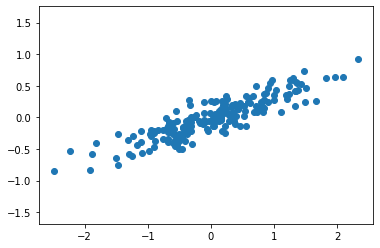

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');


By eye, it is clear that there is a nearly linear relationship between the x and y variables.
This is reminiscent of the linear regression data we explored in Linear Regression, but the problem setting here is slightly different: rather than attempting to *predict* the y values from the x values, the unsupervised learning problem attempts to learn about the *relationship* between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [2]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

*The* fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [3]:
print("Eigenvectors: ", pca.components_)
print("Eigenvalues: ", pca.explained_variance_)
print("Mean: ", pca.mean_) #center point

Eigenvectors:  [[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
Eigenvalues:  [0.7625315 0.0184779]
Mean:  [ 0.03351168 -0.00408072]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

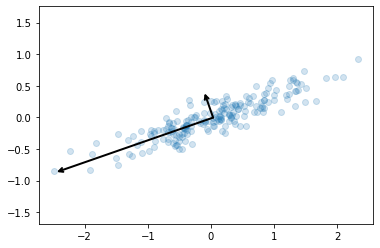

In [4]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()  #get current axis
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    #loadings = eigenvector * (unit size) * sqrt (eigenvalue)
    v = vector * 3 *  np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the *principal axes* of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.
The projection of each data point onto the principal axes are the "principal components" of the data.

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [5]:
pca = PCA(n_components=1)  #you want to transform to 1D hence n_components =1
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

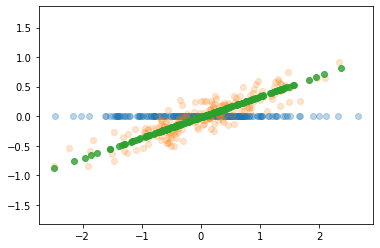

In [6]:
y = np.zeros(X_pca.shape[0])
plt.scatter(X_pca[:, 0], y, alpha=0.3)  #pca data

X_new = pca.inverse_transform(X_pca)  #inverse transform back
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)  #original data
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### Case Study: PCA on Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.

We start by loading the data:

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

**Recall** that the data consists of 8×8 pixel images, meaning that they are 64-dimensional.
To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [8]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


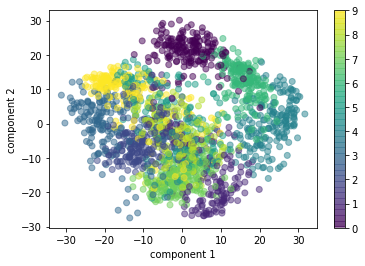

In [9]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### What do the components mean?

We can go a bit further here, and begin to ask what the reduced dimensions *mean*.
This meaning can be understood in terms of combinations of basis vectors.
For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors.
For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

![](figures/05.09-digits-pixel-components.png)

The upper row of panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image.
Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image.
Were we to continue this sequence and use all 64 pixels, we would recover the original image.

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.
The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.
This figure shows a similar depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:

![](figures/05.09-digits-pca-components.png)

Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus eight components!
The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example.
This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

### How many components?

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components:


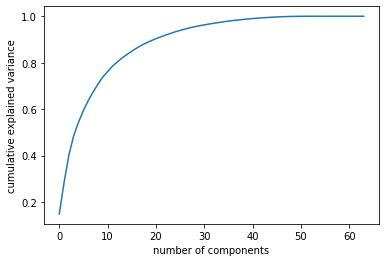

In [10]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.
For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

### When to / not to use PCA?

Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines.
Given any high-dimensional dataset, I tend to start with PCA in order to visualize the relationship between points (as we did with the digits), to understand the main variance in the data (as we did with the eigenfaces), and to understand the intrinsic dimensionality (by plotting the explained variance ratio).
Certainly PCA is not useful for every high-dimensional dataset, but it offers a straightforward and efficient path to gaining insight into high-dimensional data.

PCA's **two main weakness** is that it tends to be highly affected by outliers in the data, and its limitation to linear data.  For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components.
Scikit-Learn contains a couple interesting variants on PCA, including ``IncrementalPCA`` and ``SparsePCA``, both also in the ``sklearn.decomposition`` submodule.
``IncrementalPCA`` uses a mini-batch method to approximate principal components in very high-dimensional data, while ``SparsePCA`` introduces a regularization term that serves to enforce sparsity of the components and often gives a more interpretable model. ``KernelPCA`` is also useful as a variants of PCA for non-linear dimensionality reduction, through the use of kernels (similar to how svm transform the space)  

## Manifold learning

While PCA is flexible, fast, and easily interpretable, it does not perform well in non-linear situation.  Of course, we got kernel PCA in which it first transform the data space to another dimension in which it can find a linearly separable hyperplane.  

Here we gonna describe another class of methods known as manifold learning.  Manifold means a surface of any shape, it can be a curve, a folded sheet, etc.  Thus manifold learning is the idea of understanding the "shape" of the data and thus using this information fo cluster the data.  You can imagine paper twirling into very weird shape but it is actually just a 2d paper.  Similarly, Manifold Learning words towards extracting the low-dimensional manifold information that can be used to describe the high dimensional data.

As you may have guess, manifold learning has many things to do with distances between neighbors

![](figures/swissroll.png)

## Manifold Learning: Swiss roll

As an example of using manifold learning for visualization, let's take a look at the swiss roll dataset which is a typical dataset to look at for manifold learning.

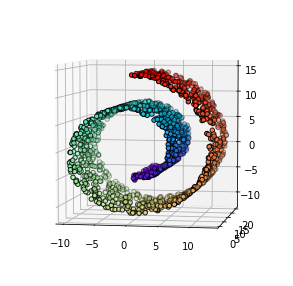

In [11]:
from sklearn import manifold, datasets

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

#elevation and #azimuth
ax.view_init(5, -80)

X, color = datasets.make_swiss_roll(n_samples=1500, noise=0.3)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap="rainbow",
          edgecolor='k')

Looking at data like this, we can see that the particular choice of *x* and *y* values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the swiss roll will still be apparent.

This tells us that the *x* and *y* values are not necessarily fundamental to the relationships in the data.
What *is* fundamental, in this case, is the *distance* between each point and the other points in the dataset.
A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.
Let's use Scikit-Learn's efficient ``pairwise_distances`` function to do this for our original data:

In [12]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
print(D.shape)
print("Distance between first point and others: ", D[0].shape)

(1500, 1500)
Distance between first point and others:  (1500,)


What is interesting is that if we rotate our swissroll, D remains the same!

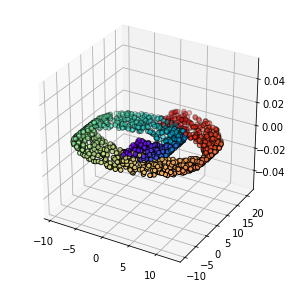

In [13]:
#https://mathworld.wolfram.com/RotationMatrix.html
#matrix rotation can be a bit confusing
#if we want to rotate around x, x is kept the same
def x_rotation(vector,theta):
    """Rotates 3-D vector around x-axis"""
    R = np.array([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0, np.sin(theta), np.cos(theta)]])
    return np.dot(vector, R)

def y_rotation(vector,theta):
    """Rotates 3-D vector around y-axis"""
    R = np.array([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta), 0, np.cos(theta)]])
    return np.dot(vector, R)

def z_rotation(vector,theta):
    """Rotates 3-D vector around z-axis"""
    R = np.array([[np.cos(theta), -np.sin(theta),0],[np.sin(theta), np.cos(theta),0],[0,0,1]])
    return np.dot(vector, R)

X_rotate = x_rotation(X, 20)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_rotate[:, 0], X_rotate[:, 1], c=color, cmap="rainbow",
          edgecolor='k')


In [14]:
D2 = pairwise_distances(X_rotate)
np.allclose(D, D2)

True

This distance matrix gives us a representation of our data that is invariant to rotations and translations.  However, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into *x* and *y* coordinates is rather difficult.  

Here, let's introduce the first manifold learning algorithm - the Multidimensional Scaling (MDS): given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data.
Let's see how it works for our distance matrix, using the ``precomputed`` dissimilarity to specify that we are passing a distance matrix:

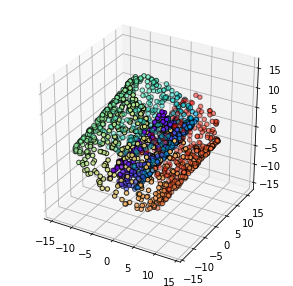

In [15]:
from sklearn.manifold import MDS
#dissimilarity='precomputed' since we already calculate the distance
#if not, use euclidean
model = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(out[:, 0], out[:, 1], out[:, 2], c=color, cmap="rainbow",
          edgecolor='k')

We can now ask the ``MDS`` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix.
The result recovers a representation of the original data:

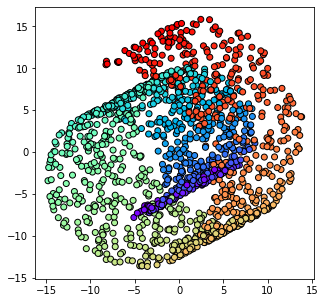

In [16]:
model = MDS(n_components=2, random_state=1)
out2 = model.fit_transform(out)
fig = plt.figure(figsize=(5, 5))
plt.scatter(out[:, 0], out[:, 1], c=color, cmap="rainbow",
          edgecolor='k')

This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.
In the case of MDS, the quantity preserved is the distance between every pair of points.

## Nonlinear Embeddings: Where MDS Fails

Our discussion thus far has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.
Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.

In non-linear embeddings, you may want to consider:

- For toy problems such as the swiss roll we saw before, locally linear embedding (LLE) and its variants (especially *modified LLE*), perform very well. This is implemented in ``sklearn.manifold.LocallyLinearEmbedding``.
- For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in ``sklearn.manifold.Isomap``
- For data that is highly clustered, *t-distributed stochastic neighbor embedding* (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in ``sklearn.manifold.TSNE``.

### LocallyLinearEmbedding

Provided there is sufficient data, we expect each data point and its neighbors to lie on or close to a locally linear patch.

Comprises of the following steps:
1. Find the k nearest neighbors
2. Do a weighted aggregation of the neighbours of each point to construct a new point, in which the cost function is to minimize the distance to neighbor points

Disadvantages:
1. Scale poorly to large datasets 

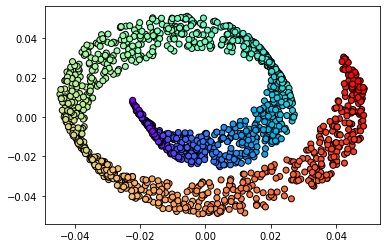

In [17]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=500, n_components=2)
out = model.fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], c=color, cmap="rainbow",
          edgecolor='k')

#### Isomap

One of the earliest approaches to manifold learning is the Isomap algorithm, short for Isometric Mapping. Isomap can be viewed as an extension of Multi-dimensional Scaling (MDS) or Kernel PCA. Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points. Isomap can be performed with the object Isomap.

The basic steps are
1. Use euclidean metrics to prepare a graph distance
2. Compute all-pairs shortest paths which output the geodesic distance on the above neighborhood graph.
3. Run multidimensional scaling using the matrix of shortest-path distances.

The disadvantage:
- Creating neighorhood graph can be tricky and if the input data is not well sampled (e.g., contain holes), then Isomap may not work well.
- Computaionally expensive

![](figures/geo.png)

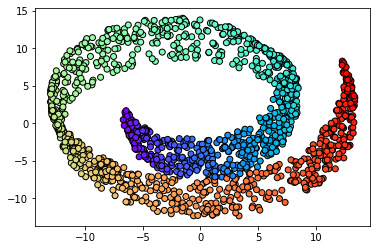

In [18]:
from sklearn.manifold import Isomap
model = Isomap(n_neighbors=500, n_components=2)
out = model.fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], c=color, cmap="rainbow",
          edgecolor='k')

### t distribution-Stochastic neighborhood embedding

tsne is about giving you clusters or local structure, and mostly used for visualization purpose.

While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples.  This tend to be useful if we want to classify things that contain multiple manifolds such as digits.

Comprises of these steps:
1. Measure similarity between two data points (e.g., distances)
2. Convert this distance to probability according to normal distribution
3. Now, it simply map the data points to a lower dimensional space
4. Calculate the similarity matrix (similar to two) but with t-distribution.  It uses t-distribution to avoid crowding problem, where points tend to be crowded in low-dimensional space
5. Using optimization algorithms (e.g., Descent algorithms with Kullback Leibler Divergence), it aims to reduce the difference between similarity matrix of 2 and 4

The disadvantages to using t-SNE are roughly:

- t-SNE is computationally expensive, and can take several hours on million-sample datasets where PCA will finish in seconds or minutes
- The algorithm is stochastic and multiple restarts with different seeds can yield different embeddings. However, it is perfectly legitimate to pick the embedding with the least error.
- Also the solution is not convex, thus descent algorithms can stuck in local minima.  We may want to initialize different random points and compare

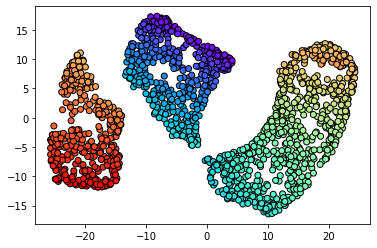

In [19]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity=100)
out = model.fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], c=color, cmap="rainbow",
          edgecolor='k')

### So what next about Manifold Learning

Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

- No mechanism for handling missing data.  PCA does.
- Sensitive to noise.  PCA filters noise from most important components
- Choosing optimal number of neighbors or other hyperparameters.  PCA does not need to
- PCA has variance_ratio to help you determine to optimal dimension to be reduced. Manifold does not
- PCA has high interpretability.  By looking at the magnitude of eigenvectors, we can gauge which features are impactful, whereas manifold learning is not always clear
- In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster 

With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data.  If for visualization purpose, then manifold learning is ok.  But for dimensionality reduction, we can always go for **Kernel PCA**, which is much faster!!

A heads up - in Artifical Neural Network (and Deep Learning), we will explore a concept called **Autoencoders** which is basically Dimensionality Reduction.  As you can already imagine, by adjusting the weights and assign an activation function, we can create a dimensionality reduction that aims to reduce unimportant features, even in non-linear space!

Last, I will leave the below code for Kernel PCA.

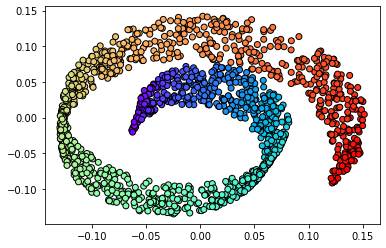

In [20]:
from sklearn.decomposition import KernelPCA
model = KernelPCA(kernel="sigmoid", n_components=2,
                 gamma=0.0003)
out = model.fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], c=color, cmap="rainbow",
          edgecolor='k')

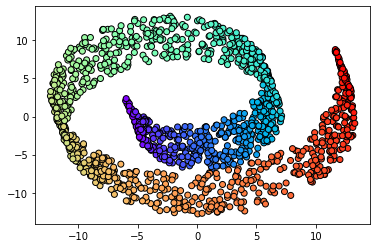

In [21]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
out = model.fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], c=color, cmap="rainbow",
          edgecolor='k')